In [66]:
import gym
import tensorflow.keras as keras
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from IPython import display

from tqdm import tqdm

# Reinforcement Learning #1

## Create an environment

In [30]:
env = gym.make('CartPole-v1')

# Initialize the environment
obs = env.reset()

Observation object contains the following information:

* cart's horizontal position, where `0.0` is center
* cart's velocity, where positive means right
* pole's angle, where `0.0` means vertical
* pole's angular velocity - positive = clockwise

In [31]:
obs

array([ 0.04178534, -0.03839284, -0.00748959,  0.01395795])

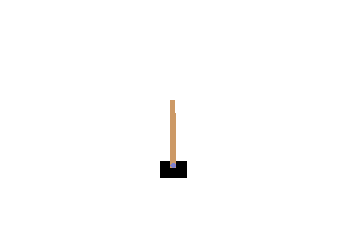

In [32]:
# Visualize the environment
plt.imshow(env.render(mode = 'rgb_array'))
plt.grid(b = None)
plt.axis('off')
plt.show()

# NOTE: To close the external render use env.close() after finishing your experiments

## Define a basic policy

To define our policy let's see what actions can we take:

In [33]:
env.action_space

Discrete(2)

There are two possible actions: accelarating the cart left (`0`) or right (`1`).

Let's create a policy that accelerates the cart left when the pole is leaening towards right and right otherwise.

Before we start, let's see how to take an action.

In [34]:
# Let's accelerate the cart right
action = 1

In [35]:
obs, reward, done, info = env.step(action)

Taking an action results in new cart and pole coordinates. We also get a reward and information if the trial has finished (either 200 iterations passed or the pole fell or the cart left the main screen) and additional info on the environment (optional).

In [42]:
def basic_policy(obs):
    pole_angle = obs[2]
    return 0 if pole_angle < 0 else 1

## Take action!

In [43]:
# Let's pick n_episodes and run the simulation with our basic_policy
N_EPISODES = 500
N_STEPS = 200

total_reward = []

for episode in tqdm(range(N_EPISODES)):
    episode_reward = 0
    obs = env.reset()
    
    for step in range(N_STEPS):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        
        if done:
            break
        
    total_reward.append(episode_reward)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1658.18it/s]


Let's see how our basic policy did!

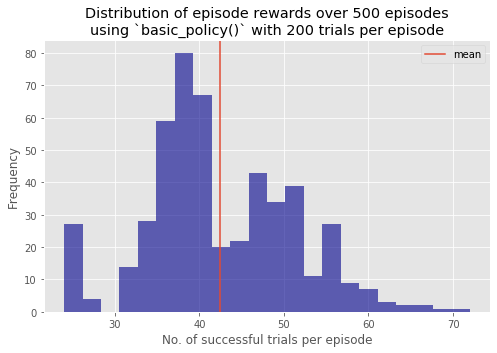

In [65]:
plt.figure(figsize = (8, 5))
plt.hist(total_reward, alpha = .6, color = 'darkblue', bins = int(np.sqrt(N_EPISODES)))
plt.axvline(np.mean(total_reward), label = 'mean')
plt.xlabel('No. of successful trials per episode')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Distribution of episode rewards over {N_EPISODES} episodes\nusing `basic_policy()` with {N_STEPS} trials per episode')
plt.show()

As we can see, our policy did not work very well. Only in very rare cases our cart was able to continue the game until ~70 trials out of 200. On average, the game was over after around 42 trials 😥

Let's see one of the games using our policy.

Done in 54 steps


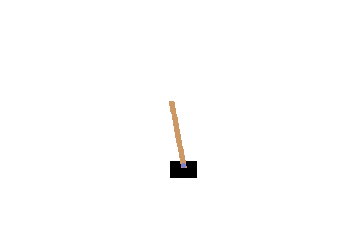

In [73]:
obs = env.reset()

for step in range(N_STEPS):
    
    # Display env and clean it
    plt.imshow(env.render(mode = 'rgb_array'))
    plt.grid(b = None)
    plt.axis('off')
    display.display(plt.gcf())    
    display.clear_output(wait = True)
#     print(step)
    
    # Take action
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
        
    if done:
        print(f'Done in {step} steps.')
        break

env.close()

## Neural Network Policy

In [12]:
# def discount(rewards, discount_factor):
    
#     discounted = np.array(rewards)
    
#     for i in range(len(rewards) - 2, -1, -1):
#         discounted[i] += discounted[i + 1] * discount_factor
    
#     return discounted

In [20]:
# discount([10, 10, 10], .8)